#  **DETR - Detection Transformer** - 커스텀 데이터셋 미세 조정

- **참조 노트북:** [DETR 커스텀 데이터셋 미세 조정 튜토리얼 (balloon)](https://github.com/NielsRogge/Transformers-Tutorials/blob/master/DETR/Fine_tuning_DetrForObjectDetection_on_custom_dataset_(balloon).ipynb)  

- **원본 DETR 논문:** [End-to-End Object Detection with Transformers (2020)](https://arxiv.org/abs/2005.12872)  

- **원본 DETR 저장소:** [Facebook Research DETR GitHub Repository](https://github.com/facebookresearch/detr)  

---

**설명:**  
- DETR는 Facebook AI Research(FAIR)에서 개발한 **객체 감지(Object Detection)**를 위한 **트랜스포머(Transformer)** 기반 모델입니다.  
- 이 모델은 기존 객체 감지 모델(예: Faster R-CNN, YOLO)과 달리, **Region Proposal Network (RPN)**과 같은 중간 단계를 제거하고 **End-to-End 학습**을 지원합니다.  
- 커스텀 데이터셋에 DETR을 미세 조정(Fine-tuning)하여 객체 감지 성능을 최적화할 수 있습니다.  


In [1]:
# Python 패키지 및 라이브러리 설치
!python -m pip install --upgrade pip

# 객체 감지 및 추적을 위한 Python 라이브러리
!pip install supervision==0.3.0

# 트랜스포머(Transformer) 모델을 사용하기 위한 라이브러리 (예: BERT, GPT, DETR)
!pip install transformers

# pytorch-lightning 라이브러리 설치
!pip install pytorch-lightning

# PyTorch용 이미지 분류 모델 라이브러리 (EfficientNet, ResNet 등)
!pip install timm

# cython 설치
!pip install cython
# Python의 C 확장을 지원하여 코드 실행 속도를 높이는 라이브러리

# COCO(Common Objects in Context) 데이터셋을 처리하기 위한 라이브러리
!pip install pycocotools

!pip install scipy

# roboflow 설치
!pip install roboflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 48.1 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 829.2/829.2 kB 30.9 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 44.4 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [pytorch-lightning]
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 63.5 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 52.6 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 136.3 MB/s  0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.12.0.88
    Uninstalling opencv-python-headless-4.12.0.88:
      Successfully uninstalled opencv-python-headless-4.12.0.88
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
   

In [2]:
import torch
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE

device(type='cuda')

## **COCO 데이터 로더 생성**

### **데이터셋 정보**

- **클래스 수:** **4개**  
- **클래스 목록:**  
   1. **angle (각도)**  
   2. **fracture (균열)**  
   3. **line (선)**  
   4. **messed_up_angle (비뚤어진 각도)**  

---

**설명:**  
- 이 데이터셋은 COCO 포맷을 따르며, 총 **4개의 클래스**로 구성되어 있습니다.  
- 각 클래스는 이미지 내 특정 객체나 패턴을 나타냅니다.  

이제 COCO 데이터셋을 불러오기 위한 데이터 로더를 구성할 준비가 되었습니다!

<img src="https://i.imgur.com/M0VVwIY.png" width=400 />

<img src="https://i.imgur.com/el1lmEJ.png"  width=400/>

Roboflow에서 제공하는 데이터셋 다운로드 (COCO 포맷)
https://universe.roboflow.com/roboflow-100/bone-fracture-7fylg/dataset/2

In [8]:
# 압축 파일 풀기
import zipfile

with zipfile.ZipFile('/content/bone fracture.v2-release.coco.zip') as target_file:
    target_file.extractall('/content/dataset/')

In [9]:
import os
# 시각화 및 객체 탐지 후처리를 위한 유틸리티 라이브러리
import supervision as sv
# 컴퓨터 비전용 데이터셋 및 모델 제공
import torchvision
# DETR 모델을 위한 이미지 전처리기
from transformers import DetrImageProcessor

# 'facebook/detr-resnet-50' 사전 학습된 모델의 이미지 전처리기 로드
image_processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")

# 데이터셋 경로 설정
dataset = './dataset/'

# COCO 포맷 어노테이션 파일 이름
ANNOTATION_FILE_NAME = "_annotations.coco.json"

# 학습, 검증, 테스트 데이터 경로 설정
TRAIN_DIRECTORY = os.path.join(dataset, "train")
VAL_DIRECTORY = os.path.join(dataset, "valid")
TEST_DIRECTORY = os.path.join(dataset, "test")

# 사용자 정의 COCO 데이터셋 클래스 생성
class CocoDetection(torchvision.datasets.CocoDetection):
    def __init__(
        self,
        image_directory_path: str,   # 이미지가 저장된 디렉터리 경로
        image_processor,                # 이미지 전처리기
        train: bool = True                 # 학습/검증 데이터 구분
    ):
        # 어노테이션 파일 경로 생성
        annotation_file_path = os.path.join(image_directory_path, ANNOTATION_FILE_NAME)
        # COCO 데이터셋 초기화
        super(CocoDetection, self).__init__(image_directory_path, annotation_file_path)
        self.image_processor = image_processor

    def __getitem__(self, idx):
        # 부모 클래스의 __getitem__ 호출하여 이미지와 어노테이션 불러오기
        images, annotations = super(CocoDetection, self).__getitem__(idx)
        image_id = self.ids[idx]       # 이미지 ID 가져오기
        annotations = {'image_id': image_id, 'annotations': annotations}  # 어노테이션 딕셔너리로 정리

        # 이미지와 어노테이션을 모델 입력 형태로 변환
        encoding = self.image_processor(images=images, annotations=annotations, return_tensors="pt")
        pixel_values = encoding["pixel_values"].squeeze()  # 이미지 텐서 추출 및 차원 축소
        target = encoding["labels"][0]                                    # 어노테이션 레이블 추출

        return pixel_values, target  # 이미지와 레이블 반환

# 학습, 검증, 테스트 데이터셋 초기화
TRAIN_DATASET = CocoDetection(image_directory_path=TRAIN_DIRECTORY, image_processor=image_processor, train=True)
VAL_DATASET = CocoDetection(image_directory_path=VAL_DIRECTORY, image_processor=image_processor, train=False)
TEST_DATASET = CocoDetection(image_directory_path=TEST_DIRECTORY, image_processor=image_processor, train=False)

# 데이터셋 크기 출력
print("Number of training examples:", len(TRAIN_DATASET))  # 학습 데이터 개수 출력
print("Number of validation examples:", len(VAL_DATASET))  # 검증 데이터 개수 출력
print("Number of test examples:", len(TEST_DATASET))  # 테스트 데이터 개수 출력

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/290 [00:00<?, ?B/s]

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Number of training examples: 326
Number of validation examples: 88
Number of test examples: 44


Image #0


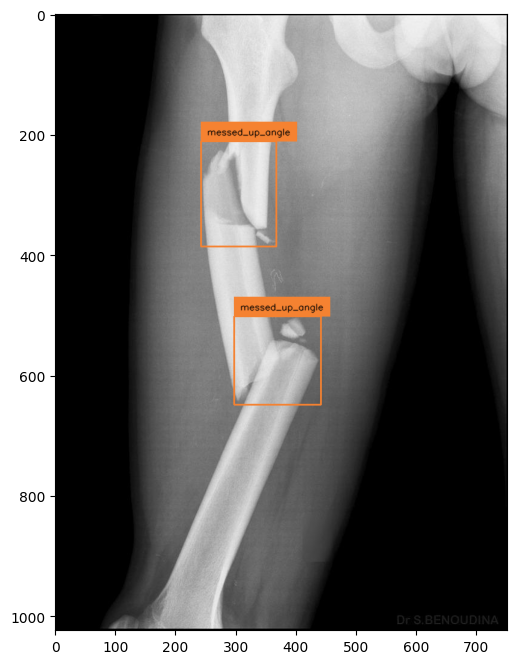

In [10]:
# 데이터셋이 올바르게 로드되었는지 시각화
import random
import cv2

# 무작위 이미지 선택
image_ids = TRAIN_DATASET.coco.getImgIds()  # COCO 데이터셋에서 이미지 ID 목록 가져오기
image_id = random.choice(image_ids)                  # 무작위로 하나의 이미지 ID 선택
print('Image #{}'.format(image_id))                         # 선택된 이미지 ID 출력

#  이미지 및 어노테이션 불러오기
image = TRAIN_DATASET.coco.loadImgs(image_id)[0]         # 이미지 메타데이터 불러오기
annotations = TRAIN_DATASET.coco.imgToAnns[image_id]  # 해당 이미지의 어노테이션 불러오기
image_path = os.path.join(TRAIN_DATASET.root, image['file_name'])  # 이미지 파일 경로 생성
image = cv2.imread(image_path)                         # OpenCV를 사용해 이미지 불러오기

# COCO 어노테이션을 Detections 객체로 변환
detections = sv.Detections.from_coco_annotations(coco_annotation=annotations)

# 클래스 ID를 레이블로 매핑
categories = TRAIN_DATASET.coco.cats  # COCO 데이터셋의 카테고리 정보 불러오기
id2label = {k: v['name'] for k, v in categories.items()}  # 카테고리 ID와 이름 매핑 (예: {1: 'angle', 2: 'fracture'})

# 어노테이션 레이블 생성
labels = [
    f"{id2label[class_id]}"  # 클래스 ID를 이름으로 변환
    for _, _, class_id, _
    in detections
]

# 바운딩 박스 어노테이션
# 바운딩 박스 시각화 도구 초기화
box_annotator = sv.BoxAnnotator()
# 이미지에 바운딩 박스와 레이블 추가
frame = box_annotator.annotate(scene=image, detections=detections, labels=labels)

# 시각화
%matplotlib inline
sv.show_frame_in_notebook(image, (8, 8))  # 이미지 표시 (크기: 8x8)

In [11]:
from torch.utils.data import DataLoader

# 데이터 배치 처리(collate function) 정의
def collate_fn(batch):
    """
    데이터 배치를 구성하기 위한 collate 함수입니다.
    각 배치에서 이미지 및 라벨 데이터를 적절한 형태로 패딩 및 병합합니다.
    """
    # 배치에서 이미지(pixel_values) 추출
    pixel_values = [item[0] for item in batch]  # 각 배치 항목에서 첫 번째 요소(이미지 텐서) 추출

    # 이미지 데이터를 패딩하여 동일한 크기로 맞춤
    encoding = image_processor.pad(pixel_values, return_tensors="pt")  # 패딩 및 텐서 변환

    # 배치에서 라벨(labels) 추출
    labels = [item[1] for item in batch]  # 각 배치 항목에서 두 번째 요소(라벨) 추출

    # 패딩된 이미지, 마스크 및 라벨 반환
    return {
        'pixel_values': encoding['pixel_values'],  # 패딩된 이미지 텐서
        'pixel_mask': encoding['pixel_mask'],      # 패딩된 이미지 마스크
        'labels': labels                           # 라벨 목록
    }

# 학습 데이터 로더 설정
TRAIN_DATALOADER = DataLoader(
    dataset=TRAIN_DATASET,           # 학습 데이터셋
    collate_fn=collate_fn,                    # 배치 데이터를 병합하는 함수
    batch_size=4,                               # 배치 크기
    shuffle=True                                 # 데이터를 무작위로 섞음
)

# 검증 데이터 로더 설정
VAL_DATALOADER = DataLoader(
    dataset=VAL_DATASET,
    collate_fn=collate_fn,
    batch_size=4
)

# 테스트 데이터 로더 설정
TEST_DATALOADER = DataLoader(
    dataset=TEST_DATASET,
    collate_fn=collate_fn,
    batch_size=4
)

# **PyTorch Lightning으로 모델 학습하기**

**DETR 모델**은 **Hugging Face Transformers** 라이브러리를 사용하여 불러옵니다.

In [12]:
# PyTorch Lightning 라이브러리
import pytorch_lightning as pl
 # DETR 객체 감지 모델
from transformers import DetrForObjectDetection

# DETR 모델 클래스 정의
class Detr(pl.LightningModule):
    def __init__(self, lr, lr_backbone, weight_decay):
        """
        DETR 모델 초기화 및 하이퍼파라미터 설정

        Args:
            lr (float): 학습률
            lr_backbone (float): 백본(backbone) 학습률
            weight_decay (float): 가중치 감쇠율 (Weight Decay)
        """
        super().__init__()

        # 사전 학습된 DETR 모델 불러오기
        self.model = DetrForObjectDetection.from_pretrained(
            pretrained_model_name_or_path="facebook/detr-resnet-50",
            num_labels=len(id2label),            # 클래스 수 지정
            ignore_mismatched_sizes=True  # 불일치하는 텐서 크기 무시
        )

        # 하이퍼파라미터 저장
        self.lr = lr        # 학습률
        self.lr_backbone = lr_backbone       # 백본 학습률
        self.weight_decay = weight_decay   # 가중치 감쇠율

    def forward(self, pixel_values, pixel_mask):
        """
        모델 예측 단계

        Args:
            pixel_values (torch.Tensor): 이미지 텐서
            pixel_mask (torch.Tensor): 패딩 영역을 나타내는 마스크 텐서

        Returns:
            모델 출력 결과 반환
        """
        return self.model(pixel_values=pixel_values, pixel_mask=pixel_mask)

    def common_step(self, batch, batch_idx):
        """
        학습 및 검증 단계에서 공통으로 수행되는 단계

        Args:
            batch (dict): 배치 데이터
            batch_idx (int): 배치 인덱스

        Returns:
            loss (torch.Tensor): 손실 값
            loss_dict (dict): 손실 항목들
        """
        pixel_values = batch["pixel_values"]       # 이미지 텐서
        pixel_mask = batch["pixel_mask"]          # 이미지 패딩 마스크
        labels = [{k: v.to(self.device) for k, v in t.items()} for t in batch["labels"]]  # 라벨을 GPU로 이동

        # 모델 예측 및 손실 계산
        outputs = self.model(pixel_values=pixel_values, pixel_mask=pixel_mask, labels=labels)
        loss = outputs.loss                 # 손실 값
        loss_dict = outputs.loss_dict  # 세부 손실 항목

        return loss, loss_dict

    def training_step(self, batch, batch_idx):
        """
        학습 단계

        Args:
            batch (dict): 배치 데이터
            batch_idx (int): 배치 인덱스

        Returns:
            loss (torch.Tensor): 학습 손실 값
        """
        loss, loss_dict = self.common_step(batch, batch_idx)  # 공통 단계 실행

        # 손실 로그 기록
        self.log("training_loss", loss)
        for k, v in loss_dict.items():
            self.log("train_" + k, v.item())

        return loss

    def validation_step(self, batch, batch_idx):
        """
        검증 단계

        Args:
            batch (dict): 배치 데이터
            batch_idx (int): 배치 인덱스

        Returns:
            loss (torch.Tensor): 검증 손실 값
        """
        loss, loss_dict = self.common_step(batch, batch_idx)  # 공통 단계 실행

        # 손실 로그 기록
        self.log("validation/loss", loss)
        for k, v in loss_dict.items():
            self.log("validation_" + k, v.item())

        return loss

    def configure_optimizers(self):
        """
        옵티마이저 및 학습률 스케줄러 설정

        Returns:
            optimizer (torch.optim.AdamW): AdamW 옵티마이저
        """
        # DETR는 백본과 다른 부분에 서로 다른 학습률을 적용
        param_dicts = [
            {
                "params": [p for n, p in self.named_parameters() if "backbone" not in n and p.requires_grad]
            },
            {
                "params": [p for n, p in self.named_parameters() if "backbone" in n and p.requires_grad],
                "lr": self.lr_backbone,
            },
        ]

        # AdamW 옵티마이저 사용
        return torch.optim.AdamW(param_dicts, lr=self.lr, weight_decay=self.weight_decay)

    def train_dataloader(self):
        """
        학습 데이터 로더 반환

        Returns:
            TRAIN_DATALOADER (DataLoader): 학습용 데이터 로더
        """
        return TRAIN_DATALOADER

    def val_dataloader(self):
        """
        검증 데이터 로더 반환

        Returns:
            VAL_DATALOADER (DataLoader): 검증용 데이터 로더
        """
        return VAL_DATALOADER

In [13]:
# DETR 모델 인스턴스 생성 및 예측 테스트

# Detr 모델 초기화
model = Detr(
    lr=1e-4,                    # 학습률 (Learning Rate)
    lr_backbone=1e-5,  # 백본(Backbone) 학습률
    weight_decay=1e-4  # 가중치 감쇠율 (Weight Decay)
)

# TRAIN_DATALOADER에서 첫 번째 배치를 가져옵니다.
# 배치에는 'pixel_values', 'pixel_mask', 'labels'가 포함됩니다.
batch = next(iter(TRAIN_DATALOADER))

# 모델 예측 수행
outputs = model(
    pixel_values=batch['pixel_values'],  # 배치에서 이미지 텐서 전달
    pixel_mask=batch['pixel_mask']       # 배치에서 이미지 마스크 전달
)

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:2441: UserWarning: for conv1.weight: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their corresponding key in the module instead of copying them in place?)
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:2441: UserWarning: for bn1.weight: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their corresponding key in the module instead of copying them in place?)
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:2441: UserWarning: for bn1.bias: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pas

10 EPOCH 에 약 20분 소요

In [14]:
%%time

# PyTorch Lightning Trainer를 사용한 모델 학습
from pytorch_lightning import Trainer

# MAX_EPOCHS = 200  # 최대 학습 에폭 수
MAX_EPOCHS = 10  # 최대 학습 에폭 수

#  Trainer 인스턴스 생성
trainer = Trainer(
    max_epochs=MAX_EPOCHS,         # 최대 에폭 수 설정
    gradient_clip_val=0.1,                # 그래디언트 클리핑 값 (그래디언트 폭발 방지)
    accumulate_grad_batches=8,    # 그래디언트를 8개의 배치에 대해 누적 (메모리 사용 최적화)
    log_every_n_steps=5               # 5 스텝마다 로그 기록
)

 # Trainer를 사용하여 모델 학습 수행
trainer.fit(model)

INFO:pytorch_lightning.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type                   | Params | Mode
--------------------------------------------------------
0 | model | DetrForObjectDetection | 41.5 M | eval
--------------------------------------------------------
41.3 M    Trainable params
222 K     Non-trainable params
41.5 M    Total params
166.011   Total estimated model params size (MB)
0         Modules in train mod

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/pytorch_lightning/utilities/data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 4. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


CPU times: user 13min 27s, sys: 1min 1s, total: 14min 29s
Wall time: 19min 47s


# Save and load model

In [15]:
MODEL_PATH = 'custom-model'  # 학습된 모델을 저장할 경로 지정

# 모델 저장: 학습된 DETR 모델을 HuggingFace 포맷으로 저장
model.model.save_pretrained(MODEL_PATH)

# 모델 불러오기: 저장된 DETR 모델을 다시 로드
model = DetrForObjectDetection.from_pretrained(MODEL_PATH)

# 모델을 실행할 장치로 이동 (예: GPU 또는 CPU)
model.to(DEVICE)

DetrForObjectDetection(
  (model): DetrModel(
    (backbone): DetrConvModel(
      (conv_encoder): DetrConvEncoder(
        (model): FeatureListNet(
          (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
          (bn1): DetrFrozenBatchNorm2d()
          (act1): ReLU(inplace=True)
          (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
          (layer1): Sequential(
            (0): Bottleneck(
              (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (bn1): DetrFrozenBatchNorm2d()
              (act1): ReLU(inplace=True)
              (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (bn2): DetrFrozenBatchNorm2d()
              (drop_block): Identity()
              (act2): ReLU(inplace=True)
              (aa): Identity()
              (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      

# **테스트 데이터셋에서 추론 수행**

**DETR 모델**의 예측 결과를 **검증 데이터셋**의 첫 번째 이미지에서 시각화해 봅시다.

In [19]:
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 유틸리티 설정
categories = TEST_DATASET.coco.cats        # COCO 데이터셋의 카테고리 정보
id2label = {k: v['name'] for k, v in categories.items()}    # 카테고리 ID와 이름 매핑
id2label

{0: 'bone-fracture',
 1: 'angle',
 2: 'fracture',
 3: 'line',
 4: 'messed_up_angle'}

In [35]:
box_annotator = sv.BoxAnnotator()                # 바운딩 박스 시각화 도구 초기화

# 무작위 이미지 선택
image_ids = TEST_DATASET.coco.getImgIds()  # 이미지 ID 목록 가져오기
image_id = random.choice(image_ids)        # 무작위 이미지 ID 선택
print('Image #{}'.format(image_id))               # 선택된 이미지 ID 출력

# 이미지 및 어노테이션 불러오기
image = TEST_DATASET.coco.loadImgs(image_id)[0]  # 이미지 메타데이터 불러오기
annotations = TEST_DATASET.coco.imgToAnns[image_id]  # 해당 이미지의 어노테이션 불러오기
image_path = os.path.join(TEST_DATASET.root, image['file_name'])  # 이미지 파일 경로 생성
image = cv2.imread(image_path)  # OpenCV를 사용해 이미지 불러오기

Image #20


In [36]:
image.shape

(1024, 946, 3)

In [37]:
annotations

[{'id': 30,
  'image_id': 20,
  'category_id': 2,
  'bbox': [447, 500, 81, 52],
  'area': 4212,
  'segmentation': [],
  'iscrowd': 0},
 {'id': 31,
  'image_id': 20,
  'category_id': 2,
  'bbox': [535, 464, 23, 52],
  'area': 1196,
  'segmentation': [],
  'iscrowd': 0}]

In [38]:
# 실제 어노테이션(Ground Truth) 시각화
# COCO 어노테이션을 Detections 객체로 변환
detections = sv.Detections.from_coco_annotations(coco_annotation=annotations)
detections

Detections(xyxy=array([[447, 500, 528, 552],
       [535, 464, 558, 516]]), class_id=array([2, 2]), confidence=None, tracker_id=None)

In [41]:
# 클래스 ID를 이름으로 변환하여 레이블 생성
labels = [f"{id2label[class_id]}" for _, _, class_id, _ in detections]
labels

['fracture', 'fracture']

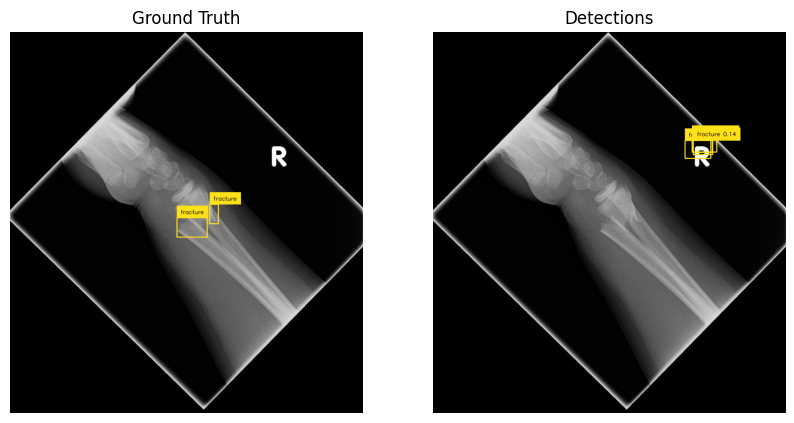

In [42]:
# 이미지에 실제 어노테이션(바운딩 박스) 그리기
frame_ground_truth = box_annotator.annotate(
    scene=image.copy(), detections=detections, labels=labels
)

# 추론(Detection) 수행
CONFIDENCE_TRESHOLD = 0.1  # 신뢰도 임계값 설정

with torch.no_grad():  # 그래디언트 계산 비활성화 (메모리 절약)
    # 이미지 전처리 및 입력 텐서 생성
    inputs = image_processor(images=image, return_tensors='pt').to(DEVICE)

    # 모델 예측 수행
    outputs = model(**inputs)

    # 결과 후처리(Post-process)
    target_sizes = torch.tensor([image.shape[:2]]).to(DEVICE)  # 원본 이미지 크기 설정
    results = image_processor.post_process_object_detection(
        outputs=outputs,
        threshold=CONFIDENCE_TRESHOLD,
        target_sizes=target_sizes
    )[0]  # 객체 감지 후처리 적용

    # DETR 모델의 예측 결과 변환
    detections = sv.Detections.from_transformers(transformers_results=results)
    labels = [
        f"{id2label[class_id]} {confidence:.2f}"
        for _, confidence, class_id, _ in detections
    ]  # 예측된 객체에 대한 레이블 생성 (클래스명 + 신뢰도)

    # 예측 결과 이미지에 시각화
    frame_detections = box_annotator.annotate(
        scene=image.copy(), detections=detections, labels=labels
    )

# 실제 어노테이션 vs 예측 결과 비교 시각화
fig, axs = plt.subplots(1, 2, figsize=(10, 10))  # 두 개의 이미지를 나란히 표시

# 실제 어노테이션 시각화
axs[0].imshow(cv2.cvtColor(frame_ground_truth, cv2.COLOR_BGR2RGB))  # OpenCV 이미지 색상 변환
axs[0].axis('off')  # 축 제거
axs[0].set_title('Ground Truth')  # 제목 설정

# 모델 예측 결과 시각화
axs[1].imshow(cv2.cvtColor(frame_detections, cv2.COLOR_BGR2RGB))  # OpenCV 이미지 색상 변환
axs[1].axis('off')  # 축 제거
axs[1].set_title('Detections')  # 제목 설정

# 이미지 표시
plt.show()